As discussed in the [Vision Transformers (ViT)](https://arxiv.org/abs/2010.11929) paper,
a Transformer-based architecture for vision typically requires a larger dataset than
usual, as well as a longer pre-training schedule. This is primarily because, unlike CNNs, ViTs (or a typical
Transformer-based architecture) do not have well-informed inductive biases (such as
convolutions for processing images). Combining the
benefits of convolution and the benefits of Transformers
in a single network architecture. These benefits include parameter-efficiency, and
self-attention to process long-range and global dependencies (interactions between
different regions in an image).

In [Escaping the Big Data Paradigm with Compact Transformers](https://arxiv.org/abs/2104.05704),
Hassani et al. present an approach for doing exactly this. They proposed the
**Compact Convolutional Transformer** (CCT) architecture. In this example, I will work on an
implementation of CCT and see how well it performs on the [SARS-COV2 Ct-Scan Dataset](https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset).

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Addons, which can
be installed using the following command:

In [1]:
!pip install -U -q tensorflow-addons

## Imports

In [2]:
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

## Hyperparameters and constants

In [3]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 40
image_size = 180

# Load COVID Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
datapath = "/content/drive/MyDrive/covidDataset"

import pathlib
def get_imagepath_and_labels(datapath):
    data_root = pathlib.Path(datapath)
    all_image_path = [str(path) for path in list(data_root.glob('*/*'))]

    label_names = sorted(item.name for item in data_root.glob('*/*'))

    all_image_label = [pathlib.Path(single_image_path).parent.name for single_image_path in all_image_path]

    return all_image_path, all_image_label

all_image_path, all_image_label = get_imagepath_and_labels(datapath)
print(len(all_image_path))
print(len(all_image_label))

2481
2481


In [10]:
import numpy as np
import cv2

def get_images_and_labels_astensor(image_path, image_labels, channels):
    images = []
    labels = []
    for i in range(0, len(image_path)):
        image = image_astensor(image_path[i], channels=channels)
        images.append(image)
        labels.append(image_labels[i])
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

def image_astensor(image_path, channels):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=channels)
        image = tf.image.resize(image, (180, 180))
        image = np.array(image).astype('float32')
        return image

images, labels = get_images_and_labels_astensor(all_image_path, all_image_label, channels=3)

In [11]:
from sklearn.model_selection import train_test_split
 
x_train, x_test, y_train, y_test = train_test_split(
    images, 
    labels, 
    test_size=400, 
    shuffle=True,
    random_state=42,
    stratify=labels
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2081, 180, 180, 3)
(2081,)
(400, 180, 180, 3)
(400,)


In [12]:
from sklearn.preprocessing import LabelEncoder
# prepare target

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [13]:
num_classes = 2
input_shape = (180, 180, 3)


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("y_train length:", y_train.shape, " y_test lenght:", y_test.shape)

y_train length: (2081, 2)  y_test lenght: (400, 2)


## The CCT tokenizer

The first recipe introduced by the CCT authors is the tokenizer for processing the
images. In a standard ViT, images are organized into uniform *non-overlapping* patches.
This eliminates the boundary-level information present in between different patches. This
is important for a neural network to effectively exploit the locality information. The
figure below presents an illustration of how images are organized into patches.

![](https://i.imgur.com/IkBK9oY.png)

We already know that convolutions are quite good at exploiting locality information. So,
based on this, the authors introduce an all-convolution mini-network to produce image
patches.

In [14]:

class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None


## Stochastic depth for regularization

[Stochastic depth](https://arxiv.org/abs/1603.09382) is a regularization technique that
randomly drops a set of layers. During inference, the layers are kept as they are. It is
very much similar to [Dropout](https://jmlr.org/papers/v15/srivastava14a.html) but only
that it operates on a block of layers rather than individual nodes present inside a
layer. In CCT, stochastic depth is used just before the residual blocks of a Transformers
encoder.

In [15]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


## MLP for the Transformers encoder

In [16]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Data augmentation

In the [original paper](https://arxiv.org/abs/2104.05704), the authors use
[AutoAugment](https://arxiv.org/abs/1805.09501) to induce stronger regularization. For
this example, we will be using the standard geometric augmentations like random cropping
and flipping.

In [17]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomCrop(image_size, image_size),
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

## The final CCT model

Another recipe introduced in CCT is attention pooling or sequence pooling. In ViT, only
the feature map corresponding to the class token is pooled and is then used for the
subsequent classification task (or any other downstream task). In CCT, outputs from the
Transformers encoder are weighted and then passed on to the final task-specific layer (in
this example, we do classification).

In [18]:
path = "/content/drive/MyDrive/ViT/models"

In [19]:

def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Model training and evaluation

In [20]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            # keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = path + "/test1/cct"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/40
117/117 [==============================] - 43s 340ms/step - loss: 0.8089 - accuracy: 0.5262 - val_loss: 0.7216 - val_accuracy: 0.4928
Epoch 2/40
117/117 [==============================] - 40s 341ms/step - loss: 0.6723 - accuracy: 0.5860 - val_loss: 0.6539 - val_accuracy: 0.5981
Epoch 3/40
117/117 [==============================] - 40s 345ms/step - loss: 0.6437 - accuracy: 0.6373 - val_loss: 0.6843 - val_accuracy: 0.6220
Epoch 4/40
117/117 [==============================] - 41s 349ms/step - loss: 0.5840 - accuracy: 0.7147 - val_loss: 0.6732 - val_accuracy: 0.6555
Epoch 5/40
117/117 [==============================] - 41s 354ms/step - loss: 0.6319 - accuracy: 0.6640 - val_loss: 0.6037 - val_accuracy: 0.6603
Epoch 6/40
117/117 [==============================] - 42s 356ms/step - loss: 0.5560 - accuracy: 0.7500 - val_loss: 0.5654 - val_accuracy: 0.7512
Epoch 7/40
117/117 [==============================] - 41s 354ms/step - loss: 0.6045 - accuracy: 0.6939 - val_loss: 0.6205 - val_ac

Let's now visualize the training progress of the model.

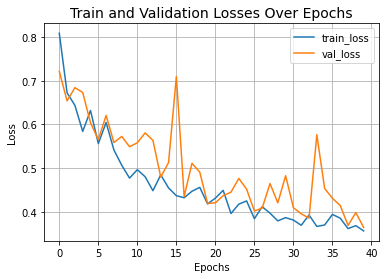

In [21]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

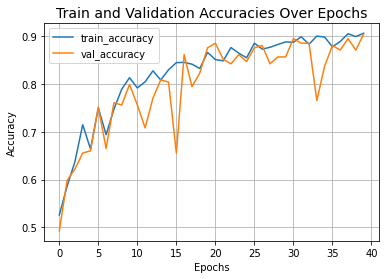

In [22]:
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracies Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [23]:
cct_model = create_cct_model()
optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

cct_model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            # keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
        )
cct_model.load_weights(path+"/test1/cct")
cct_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 180, 180, 3)  0          ['input_2[0][0]']                
                                                                                                  
 cct_tokenizer_1 (CCTTokenizer)  (None, 2025, 128)   75456       ['data_augmentation[1][0]']      
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 2025, 128)   0           ['cct_tokenizer_1[0][0]']  

The CCT model we just trained has just **0.4 million** parameters, and it gets us to
~88% top-1 accuracy within 40 epochs. The plot above shows no signs of overfitting as
well. This means we can train this network for longer (perhaps with a bit more
regularization) and may obtain even better performance. This performance can further be
improved by additional recipes like cosine decay learning rate schedule, other data augmentation
techniques like [AutoAugment](https://arxiv.org/abs/1805.09501),
[MixUp](https://arxiv.org/abs/1710.09412) or
[Cutmix](https://arxiv.org/abs/1905.04899). With these modifications, the authors present
95.1% top-1 accuracy on the CIFAR-10 dataset. The authors also present a number of
experiments to study how the number of convolution blocks, Transformers layers, etc.
affect the final performance of CCTs.

For a comparison, a ViT model takes about **4.7 million** parameters and **100
epochs** of training to reach a top-1 accuracy of 78.22% on the CIFAR-10 dataset. You can
refer to
[this notebook](https://colab.research.google.com/gist/sayakpaul/1a80d9f582b044354a1a26c5cb3d69e5/image_classification_with_vision_transformer.ipynb)
to know about the experimental setup.

The authors also demonstrate the performance of Compact Convolutional Transformers on
NLP tasks and they report competitive results there.